In [1]:
import os
cwd = os.getcwd()
jaxqualin_path = os.path.join(cwd, os.pardir, os.pardir)

In [2]:
import sys
sys.path.insert(0, jaxqualin_path)

In [3]:
import postprocess
from postprocess import *
from pathlib import Path
import matplotlib.pyplot as plt
import plot

import os
import configparser

2023-09-01 09:32:52.104493: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-09-01 09:32:52.139953: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-09-01 09:32:52.142717: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIB

In [4]:
from importlib import reload

In [5]:
reload(postprocess)
from postprocess import *

In [6]:
ROOT_PATH = jaxqualin_path
CONFIG_PATH = os.path.join(ROOT_PATH, "config")

In [7]:
batch_runname = "eff3_a_0.7"
eff_num_len = 10
kwargs_in = {}

setting_name = "normal2"

In [8]:
ROOT_PATH = jaxqualin_path
PLOT_PATH = os.path.join(ROOT_PATH, f"plots/{setting_name}/")
PLOT_PATH_ROOT = os.path.join(ROOT_PATH, f"plots/")

In [9]:
config_file_path = os.path.join(CONFIG_PATH, f"{setting_name}.ini")
config = configparser.ConfigParser()
config.optionxform = str

config.read(config_file_path)
config_sections = config._sections
kwargs = config_sections['basic']
flatness_checker_kwargs = config_sections['flatness_checker']
mode_searcher_kwargs = config_sections['mode_searcher']
for key in kwargs:
    kwargs[key] = eval(kwargs[key])
for key in flatness_checker_kwargs:
    flatness_checker_kwargs[key] = eval(flatness_checker_kwargs[key])
for key in mode_searcher_kwargs:
    mode_searcher_kwargs[key] = eval(mode_searcher_kwargs[key])


kwargs.update(kwargs_in, flatness_checker_kwargs = flatness_checker_kwargs,
               mode_searcher_kwargs = mode_searcher_kwargs)

In [10]:
eff_num_list = list(range(eff_num_len))
ROOT_PATH = jaxqualin_path
df_path = os.path.join(ROOT_PATH, f"pickle/data_frame/{batch_runname}.csv")
df_indiv_path = os.path.join(ROOT_PATH, f"pickle/data_frame/{batch_runname}")

run_modesearch = False

# df = create_data_frame_eff(eff_num_list, batch_runname, df_save_prefix = batch_runname,
#                            l = 2, m = 2, **kwargs)

if run_modesearch:
    df_file = Path(df_path)
    if df_file.is_file():
        df = pd.read_csv(df_path)
    else:
        df = create_data_frame_eff(eff_num_list, batch_runname, df_save_prefix = batch_runname,
                            l = 2, m = 2, **kwargs)
else:
    for i in eff_num_list:
        try:
            df_i = pd.read_csv(df_indiv_path + f"/{batch_runname}_{i:03d}.csv")
            if i == 0:
                df = df_i
            else:
                df = pd.concat([df, df_i])
        except:
            pass


In [11]:
def lost_spur_combination_str(lost_modes, spur_modes):
    lost_str = ' | '.join(lost_modes).replace('.',r'{,}').replace('-', '\! - \!').replace('constant', r'{\rm constant}')
    spur_str = ' | '.join(spur_modes).replace('.',r'{,}').replace('-', '\! - \!').replace('constant', r'{\rm constant}')
    if lost_str == '' and spur_str == '':
        return ''
    elif spur_str == '':
        return f"lost: ${lost_str}$"
    elif lost_str == '':
        return f"spurious: ${spur_str}$"
    else:
        return f"lost: ${lost_str}$\n spurious: ${spur_str}$"
    

In [12]:
from matplotlib.legend_handler import HandlerTuple

In [13]:
def string_replace(string, physical_notation = True):
    if string == 'constant':
        return string
    lmnx = str_to_lmnx(string)
    lmnstrings = []
    for lmn in lmnx:
        l, m, n = tuple(lmn)
        if l < 0:
            lmnstrings.append(f"{-l}.{-m}.{n}")
        elif m < 0:
            lmnstrings.append(f"r{l}.{-m}.{n}")
        else:
            lmnstrings.append(f"{l}.{m}.{n}")
    lmnx_string = 'x'.join(lmnstrings)
    _string_raw = '$' + lmnx_string + '$'
    _string = _string_raw.replace('99', '0')
    _tex_string = _string.replace('x', r" \! \times \! ")
    _tex_string = _tex_string.replace('-', r" \! - \! ")
    _tex_string = _tex_string.replace('.', r"{,}")
    return _tex_string

In [14]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

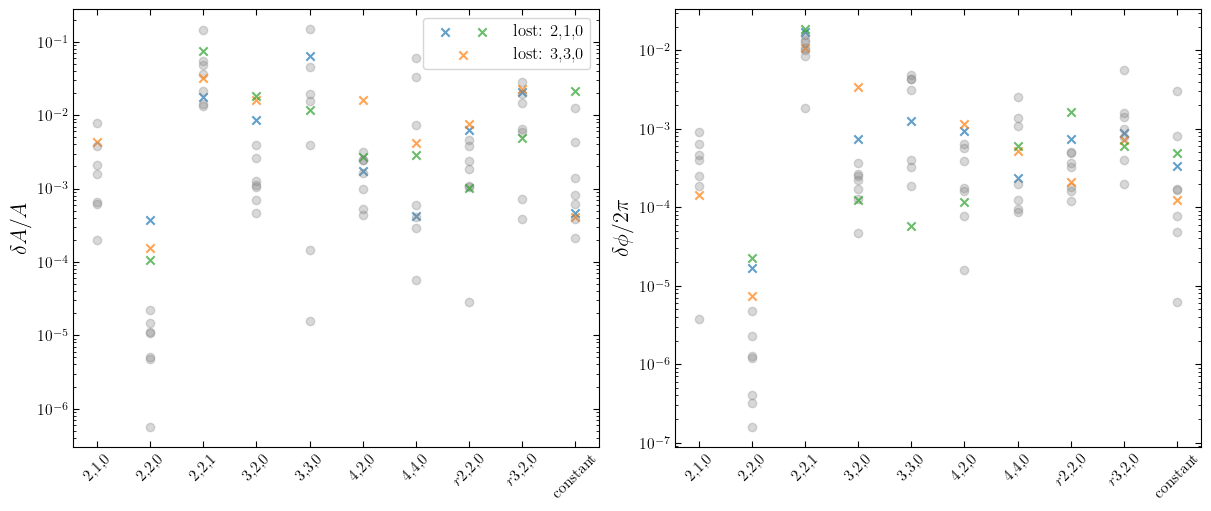

In [15]:
# fig, axs = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']],
#                               constrained_layout=True, figsize = (12, 5),
#                               height_ratios = (16, 1)
#                               )

fig, axs = plt.subplot_mosaic([['left', 'right']],
                              constrained_layout=True, figsize = (12, 5),
                              )

spur_modes_list = []
lost_modes_list = []
real_modes_list = []

colori = 0

spur_modes_indicator = []
lost_modes_indicator = []

lost_spur_combination_list = []
legend_labels_dict = {}

for i in range(eff_num_len):
    df_num = df[df["eff_num"] == i]

    param_dict = read_json_for_param_dict(i, batch_runname)

    inj_dict = param_dict['inj_dict']
    inj_mode_list = list(inj_dict.keys())
    found_mode_list = df_num.mode_string.values

    spur_modes = []
    lost_modes = []
    real_modes = []

    for mode in found_mode_list:
        if mode in inj_mode_list:
            real_modes.append(mode)
        else:
            spur_modes.append(mode)
            
    for mode in inj_mode_list:
        if mode not in found_mode_list:
            lost_modes.append(mode)

    spur_mode_exist = len(spur_modes) > 0
    lost_mode_exist = len(lost_modes) > 0

    color = f'C{colori}'
    alpha = 0.7
    colori += 1


    lost_spur_combination = [lost_modes, spur_modes]
    lost_spur_str = lost_spur_combination_str(lost_modes, spur_modes)
    

    if spur_mode_exist and lost_mode_exist:
        scatter_marker = 'D'
    elif spur_mode_exist:
        scatter_marker = '+'
    elif lost_mode_exist:
        scatter_marker = 'x'
    else:
        scatter_marker = 'o'
        color = 'gray'
        colori -= 1
        alpha = 0.3

    all_modes = real_modes + spur_modes + lost_modes
    all_modes_tex = [string_replace(mode) for mode in all_modes]
    all_modes_tex.sort()
    None_list = [None] * len(all_modes_tex)
    axs['left'].plot(all_modes_tex, None_list, marker = scatter_marker, c = color, alpha = alpha)
    axs['right'].plot(all_modes_tex, None_list, marker = scatter_marker, c = color, alpha = alpha)
    
    for j, mode in enumerate(real_modes):
        mode_row = df_num[df_num["mode_string"] == mode]
        A_med = mode_row["A_med"].values[0]
        phi_med = mode_row["phi_med"].values[0]
        A_inj, phi_inj = tuple(inj_dict[mode])
        ci = inj_mode_list.index(mode)
        plot = axs['left'].scatter(string_replace(mode), np.abs((A_med - A_inj)/A_inj), marker = scatter_marker, c = color, alpha = alpha)
        axs['right'].scatter(string_replace(mode), min(np.abs((phi_med%(2*np.pi) - phi_inj%(2*np.pi))/(2*np.pi)),
                                1 - np.abs((phi_med%(2*np.pi) - phi_inj%(2*np.pi))/(2*np.pi))),
                        marker = scatter_marker, 
            c = color, alpha = alpha)
        if j == 0:
            if spur_mode_exist or lost_mode_exist:
                if lost_spur_str in legend_labels_dict:
                    legend_labels_dict[lost_spur_str].append(plot)
                else:
                    legend_labels_dict[lost_spur_str] = [plot]

    spur_modes_list.append(spur_modes)
    lost_modes_list.append(lost_modes)
    real_modes_list.append(real_modes)

keys = []
values = []
for key, value in legend_labels_dict.items():
    keys.append(key)
    values.append(tuple(value))

legend = axs['left'].legend(values, keys, scatterpoints = 1, 
                            handler_map={tuple: HandlerTuple(ndivide = None)},
                            handletextpad=1, handlelength = 4)


axs['left'].set_yscale("log")
axs['right'].set_yscale("log")
axs['left'].tick_params('x', rotation = 45)
axs['right'].tick_params('x', rotation = 45)
axs['left'].set_ylabel("$\delta A / A$", fontsize = 16)
axs['right'].set_ylabel("$\delta \phi / 2 \pi$", fontsize = 16)


# all_real_modes = []
# all_real_modes_num = []
# all_spur_modes = []
# all_spur_modes_num = []

# for i in range(eff_num_len):
#     real_modes = real_modes_list[i]
#     spur_modes = spur_modes_list[i]
#     lost_modes = lost_modes_list[i]
#     for mode in real_modes:
#         if mode not in all_real_modes:
#             all_real_modes.append(mode)
#             all_real_modes_num.append(1)
#         else:
#             indx = all_real_modes.index(mode)
#             all_real_modes_num[indx] += 1
#     for mode in spur_modes:
#         if mode not in all_spur_modes:
#             all_spur_modes.append(mode)
#             all_spur_modes_num.append(1)
#         else:
#             indx = all_spur_modes.index(mode)
#             all_spur_modes_num[indx] += 1


# cellText = all_real_modes_num + all_spur_modes_num
# colLabels = all_real_modes + all_spur_modes
# cellTextstr = [[str(num) for num in cellText]]
# colcolors = ['white'] * len(all_real_modes_num) + ['red'] * len(all_spur_modes_num)
# axs['bottom'].set_axis_off()
# table = axs['bottom'].table(cellText = cellTextstr,
#                             rowLabels = ['Count'], colLabels = colLabels,
#                  colColours=colcolors, cellLoc='center')
            

# fig.suptitle(batch_runname, fontsize = 20)
# fig.tight_layout()

plt.savefig(PLOT_PATH + f"effplots/{batch_runname}_delta.pdf", bbox_inches = "tight")
plt.savefig(PLOT_PATH + f"effplots/{batch_runname}_delta.png", dpi = 150, bbox_inches = "tight",
            facecolor='white', transparent=False)

In [31]:
print(real_modes)

['2.-2.0', '2.2.0', '2.2.1', '3.-2.0', '3.2.0', '4.4.0', 'constant']


In [12]:
legend_labels_dict

{'lost: 2.2.2, 2.2.3, 2.2.4': [<matplotlib.collections.PathCollection at 0x1554fce58be0>,
 'lost: 2.2.2, 2.2.3, 2.2.4\n spurious: 5.2.0': [<matplotlib.collections.PathCollection at 0x1554fce58580>],
 'lost: 2.2.2, 2.2.3, 2.2.4, 2.1.0': [<matplotlib.collections.PathCollection at 0x1554fccf0430>],
 'lost: 2.2.2, 2.2.3, 2.2.4, 3.3.0': [<matplotlib.collections.PathCollection at 0x1554fcce2f70>,
 'lost: 2.2.2, 2.2.3, 2.2.4, 2.1.0, 3.3.0': [<matplotlib.collections.PathCollection at 0x1554fcbe64f0>]}

In [13]:
all_real_modes = []
all_real_modes_num = []
all_spur_modes = []
all_spur_modes_num = []

for i in range(eff_num_len):
    real_modes = real_modes_list[i]
    spur_modes = spur_modes_list[i]
    lost_modes = lost_modes_list[i]
    for mode in real_modes:
        if mode not in all_real_modes:
            all_real_modes.append(mode)
            all_real_modes_num.append(1)
        else:
            indx = all_real_modes.index(mode)
            all_real_modes_num[indx] += 1
    for mode in spur_modes:
        if mode not in all_spur_modes:
            all_spur_modes.append(mode)
            all_spur_modes_num.append(1)
        else:
            indx = all_spur_modes.index(mode)
            all_spur_modes_num[indx] += 1


In [14]:
print(list(zip(all_real_modes, all_real_modes_num)))
print(list(zip(all_spur_modes, all_spur_modes_num)))

[('2.2.0', 10), ('2.2.1', 10), ('2.-2.0', 10), ('3.3.0', 7), ('4.2.0', 10), ('3.-2.0', 10), ('3.2.0', 10), ('2.1.0', 8), ('4.4.0', 10), ('constant', 10)]
[('5.2.0', 1)]


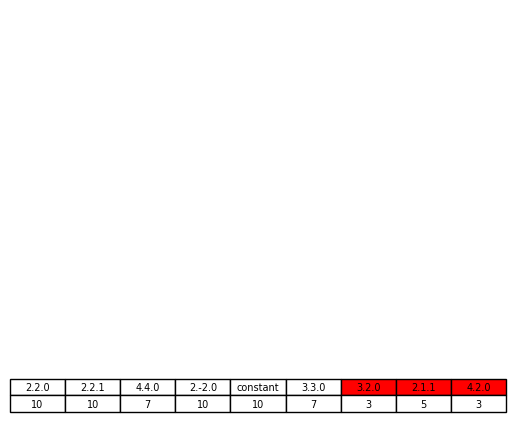

In [12]:
fig, ax = plt.subplots()

cellText = all_real_modes_num + all_spur_modes_num
colLabels = all_real_modes + all_spur_modes
cellTextstr = [[str(num) for num in cellText]]
colcolors = ['white'] * len(all_real_modes_num) + ['red'] * len(all_spur_modes_num)
ax.set_axis_off()
table = ax.table(cellText = cellTextstr, colLabels = colLabels,
                 colColours=colcolors, cellLoc='center')

['constant', '4.4.0', '2.-2.0', '3.3.0', '2.2.0', '2.2.1']
[]
['2.1.0']


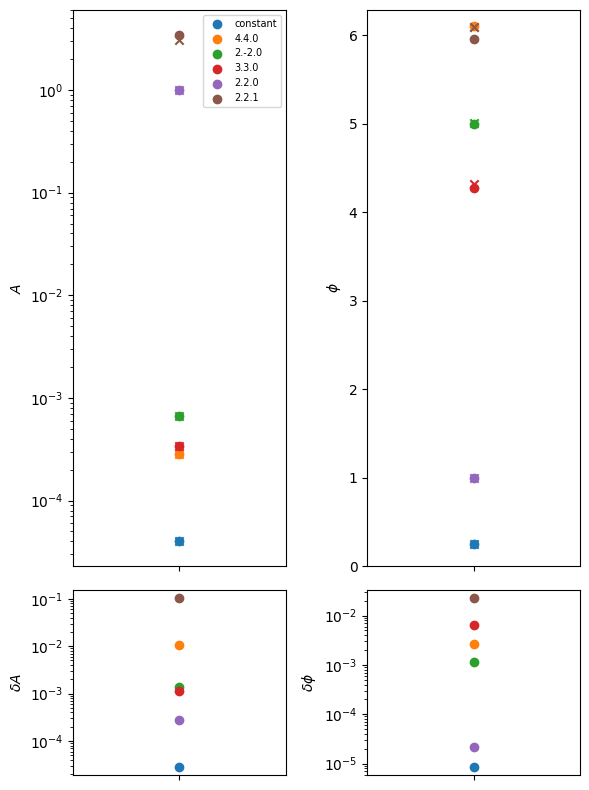

In [13]:
i = 3
df_num = df[df["eff_num"] == i]

param_dict = read_json_for_param_dict(i, batch_runname)

inj_dict = param_dict['inj_dict']
inj_mode_list = list(inj_dict.keys())
found_mode_list = df_num.mode_string.values
spur_modes = []
lost_modes = []
real_modes = []

for mode in found_mode_list:
    if mode in inj_mode_list:
        real_modes.append(mode)
    else:
        spur_modes.append(mode)
        
for mode in inj_mode_list:
    if mode not in found_mode_list:
        lost_modes.append(mode)

print(real_modes)
print(spur_modes)
print(lost_modes)
fig, axs = plt.subplots(2, 2, height_ratios=[3, 1], figsize = (6, 8))

for i, mode in enumerate(real_modes):
    mode_row = df_num[df_num["mode_string"] == mode]
    A_med = mode_row["A_med"].values[0]
    phi_med = mode_row["phi_med"].values[0]
    A_inj, phi_inj = tuple(inj_dict[mode])
    axs[0, 0].scatter('', A_med, c = f"C{i}", label = mode)
    axs[0, 0].scatter('', A_inj, marker = 'x', c = f"C{i}")
    axs[1, 0].scatter('', np.abs((A_med - A_inj)/A_inj), c = f"C{i}")
    axs[0, 1].scatter('', phi_med%(2*np.pi), c = f"C{i}")
    axs[0, 1].scatter('', phi_inj%(2*np.pi), marker = 'x', c = f"C{i}")
    axs[1, 1].scatter('', np.abs((phi_med%(2*np.pi) - phi_inj%(2*np.pi))/(2*np.pi)),
                      c = f"C{i}")

axs[0, 0].set_yscale("log")
axs[0, 0].legend(fontsize = 7)
axs[0, 1].set_ylim(0, 2*np.pi)
axs[1, 0].set_yscale("log")
axs[1, 1].set_yscale("log")
# axs[1].set_yticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
# axs[1].set_yticklabels([0, r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])

axs[0, 0].set_ylabel("$A$")
axs[0, 1].set_ylabel("$\phi$")
axs[1, 0].set_ylabel("$\delta A$")
axs[1, 1].set_ylabel("$\delta \phi$")

fig.tight_layout()